# Análise de Variação de Preço: Comparação USD/BRL x USDT/BRL

Este notebook realiza uma análise comparativa entre os pares USD/BRL e USDT/BRL.
---

## 1. Importação de Bibliotecas Necessárias



In [42]:
# Importar bibliotecas necessárias
import requests
import pandas as pd
import numpy as np
import time
import datetime
import logging
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import pearsonr
import warnings

# Configurar logging para auditabilidade
logging.basicConfig(filename='data_collection.log', level=logging.INFO,
                    format='%(asctime)s %(levelname)s:%(message)s')

# Ignorar avisos para manter a saída limpa
warnings.filterwarnings('ignore')

---

## 2. Configurações Iniciais


In [43]:
# Definir chave de API da Alpha Vantage
API_KEY_ALPHA_VANTAGE = 'YCHI2QKJE0WPT474'  # Substitua pela sua chave de API

# Definir datas de início e fim para o período de análise (últimos 6 meses)
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=180)

---

## 3. Funções Auxiliares

In [44]:
# Função para criar sessão com mecanismos de retry e backoff
def create_session():
    session = requests.Session()
    retry = Retry(connect=5, backoff_factor=1, status_forcelist=[429, 500, 502, 503, 504])
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    return session

# Função para coletar dados de USD/BRL da Alpha Vantage
def fetch_usd_brl_data(api_key, start_date, end_date):
    logging.info('Iniciando coleta de dados USD/BRL')
    url = f'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=USD&to_symbol=BRL&outputsize=full&apikey={api_key}'
    session = create_session()
    try:
        response = session.get(url)
        data = response.json()
        time_series = data['Time Series FX (Daily)']
        df = pd.DataFrame.from_dict(time_series, orient='index', dtype='float')
        df.index = pd.to_datetime(df.index)
        df.sort_index(inplace=True)
        df = df[(df.index >= start_date) & (df.index <= end_date)]
        df = df[['4. close']]
        df.rename(columns={'4. close': 'USD/BRL'}, inplace=True)
        logging.info('Coleta de dados USD/BRL concluída com sucesso')
        return df
    except Exception as e:
        logging.error(f'Erro na coleta de dados USD/BRL: {e}')
        raise

# Função para coletar dados de USDT/BRL da Binance
def fetch_usdt_brl_data(start_date, end_date):
    logging.info('Iniciando coleta de dados USDT/BRL')
    klines = []
    base_url = 'https://api.binance.com/api/v3/klines'
    symbol = 'USDTBRL'
    interval = '1h'
    start_ts = int(start_date.timestamp() * 1000)
    end_ts = int(end_date.timestamp() * 1000)
    limit = 1000  # Limite máximo por requisição

    session = create_session()
    while start_ts < end_ts:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_ts,
            'endTime': end_ts,
            'limit': limit
        }
        try:
            response = session.get(base_url, params=params)
            data = response.json()
            if not data:
                break
            klines.extend(data)
            start_ts = data[-1][0] + 1  # Incrementa para o próximo timestamp
            time.sleep(0.1)  # Pausa para evitar limites de taxa
        except Exception as e:
            logging.error(f'Erro na coleta de dados USDT/BRL: {e}')
            raise

    # Criar DataFrame
    columns = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
               'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
               'Taker buy quote asset volume', 'Ignore']
    df = pd.DataFrame(klines, columns=columns)
    df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
    df.set_index('Open time', inplace=True)
    df = df[['Close']]
    df.rename(columns={'Close': 'USDT/BRL'}, inplace=True)
    df['USDT/BRL'] = df['USDT/BRL'].astype(float)
    logging.info('Coleta de dados USDT/BRL concluída com sucesso')
    return df

---

## 4. Coleta de Dados

In [45]:
# Coletar dados de USD/BRL
df_usd_brl = fetch_usd_brl_data(API_KEY_ALPHA_VANTAGE, start_date, end_date)

# Coletar dados de USDT/BRL
df_usdt_brl = fetch_usdt_brl_data(start_date, end_date)

---

## 5. Processamento dos Dados


In [46]:
# Sincronizar os índices dos DataFrames
df_usd_brl_hourly = df_usd_brl.resample('H').ffill()

# Unir os DataFrames
df_merged = df_usdt_brl.join(df_usd_brl_hourly, how='inner')
df_merged.dropna(inplace=True)

# Visualizar as primeiras linhas
df_merged.head()

,USDT/BRL,USD/BRL
2024-03-21 00:00:00,5.017,4.9745
2024-03-21 01:00:00,5.019,4.9745
2024-03-21 02:00:00,5.018,4.9745
2024-03-21 03:00:00,5.018,4.9745
2024-03-21 04:00:00,5.016,4.9745


---

## 6. Divisão de Blocos de Tempo

In [47]:
# Função para atribuir blocos de tempo
def assign_time_blocks(df):
    def get_time_block(row):
        hour = row.hour
        if row.weekday() >= 5:  # Fim de semana
            return f'Bloco {((hour)//4)+1} (Fim de Semana)'
        else:
            if 9 <= hour < 13:
                return 'Bloco 1'
            elif 13 <= hour < 17:
                return 'Bloco 2'
            elif 17 <= hour < 18:
                return 'Bloco 2.1'
            elif 18 <= hour < 22:
                return 'Bloco 3'
            elif 22 <= hour or hour < 2:
                return 'Bloco 4'
            elif 2 <= hour < 6:
                return 'Bloco 5'
            elif 6 <= hour < 9:
                return 'Bloco 6'
            else:
                return 'Fora de Alcance'

    df = df.copy()
    df['Bloco de Tempo'] = df.index.map(get_time_block)
    return df

# Atribuir blocos de tempo
df_merged = assign_time_blocks(df_merged)

# Visualizar as primeiras linhas com o bloco de tempo
df_merged.head()

,USDT/BRL,USD/BRL,Bloco de Tempo
2024-03-21 00:00:00,5.017,4.9745,Bloco 4
2024-03-21 01:00:00,5.019,4.9745,Bloco 4
2024-03-21 02:00:00,5.018,4.9745,Bloco 5
2024-03-21 03:00:00,5.018,4.9745,Bloco 5
2024-03-21 04:00:00,5.016,4.9745,Bloco 5


---

## 7. Cálculo das Diferenças Percentuais


In [48]:
# Calcular diferença percentual
df_merged['Diferença Percentual'] = ((df_merged['USDT/BRL'] - df_merged['USD/BRL']) / df_merged['USD/BRL']) * 100

# Visualizar as primeiras linhas com a diferença percentual
df_merged.head()

,USDT/BRL,USD/BRL,Bloco de Tempo,Diferença Percentual
2024-03-21 00:00:00,5.017,4.9745,Bloco 4,0.854357
2024-03-21 01:00:00,5.019,4.9745,Bloco 4,0.894562
2024-03-21 02:00:00,5.018,4.9745,Bloco 5,0.874460
2024-03-21 03:00:00,5.018,4.9745,Bloco 5,0.874460
2024-03-21 04:00:00,5.016,4.9745,Bloco 5,0.834255


---

## 8. Análise Estatística por Bloco


In [49]:
# Calcular estatísticas por bloco
stats = df_merged.groupby('Bloco de Tempo')['Diferença Percentual'].agg(['mean', 'max', 'min']).reset_index()

# Renomear colunas para melhor legibilidade
stats.rename(columns={'mean': 'Média', 'max': 'Máximo', 'min': 'Mínimo'}, inplace=True)

# Visualizar as estatísticas
stats

,Bloco de Tempo,Média,Máximo,Mínimo
0,Bloco 1,0.530351,6.626580,-1.751060
1,Bloco 1 (Fim de Semana),0.880612,4.199644,-1.607970
2,Bloco 2,0.479024,5.070880,-1.349424
3,Bloco 2 (Fim de Semana),0.869774,4.570948,-1.482767
4,Bloco 2.1,0.446065,1.615521,-1.482767
5,Bloco 3,0.523394,2.413878,-1.572198
6,Bloco 3 (Fim de Semana),0.884084,3.886967,-1.482767
7,Bloco 4,0.535551,3.742418,-1.912036
8,Bloco 4 (Fim de Semana),0.961147,4.336441,-1.321791
9,Bloco 5,0.524349,4.144453,-2.340928


---

## 9. Visualização Interativa dos Resultados


In [50]:
# Gráfico das diferenças percentuais ao longo do tempo
fig = px.line(df_merged, x=df_merged.index, y='Diferença Percentual', color='Bloco de Tempo',
              title='Diferença Percentual ao Longo do Tempo')
fig.update_layout(xaxis_title='Data e Hora', yaxis_title='Diferença Percentual (%)')
fig.show()

In [51]:
# Gráfico das estatísticas por bloco
fig_stats = go.Figure()
fig_stats.add_trace(go.Bar(x=stats['Bloco de Tempo'], y=stats['Média'], name='Média'))
fig_stats.add_trace(go.Bar(x=stats['Bloco de Tempo'], y=stats['Máximo'], name='Máximo'))
fig_stats.add_trace(go.Bar(x=stats['Bloco de Tempo'], y=stats['Mínimo'], name='Mínimo'))
fig_stats.update_layout(title='Estatísticas de Diferença Percentual por Bloco',
                        xaxis_title='Bloco de Tempo', yaxis_title='Diferença Percentual (%)',
                        barmode='group')
fig_stats.show()

---

## 10. Identificação de Padrões e Anomalias


In [52]:
# Identificar períodos com diferenças percentuais altas
threshold_high = df_merged['Diferença Percentual'].mean() + 2 * df_merged['Diferença Percentual'].std()
high_diff = df_merged[df_merged['Diferença Percentual'] > threshold_high]

# Identificar períodos com diferenças percentuais baixas
threshold_low = df_merged['Diferença Percentual'].mean() - 2 * df_merged['Diferença Percentual'].std()
low_diff = df_merged[df_merged['Diferença Percentual'] < threshold_low]

# Exibir períodos com diferenças altas
print("Períodos com Diferença Percentual Alta:")
display(high_diff)

# Exibir períodos com diferenças baixas
print("Períodos com Diferença Percentual Baixa:")
display(low_diff)

Períodos com Diferença Percentual Alta:


,USDT/BRL,USD/BRL,Bloco de Tempo,Diferença Percentual
2024-04-13 18:00:00,5.210,5.0904,Bloco 5 (Fim de Semana),2.349521
2024-04-13 19:00:00,5.243,5.0904,Bloco 5 (Fim de Semana),2.997800
2024-04-13 20:00:00,5.369,5.0904,Bloco 6 (Fim de Semana),5.473047
2024-04-13 21:00:00,5.380,5.0904,Bloco 6 (Fim de Semana),5.689140
2024-04-13 22:00:00,5.398,5.0904,Bloco 6 (Fim de Semana),6.042747
...,...,...,...,...
2024-08-08 05:00:00,5.668,5.5461,Bloco 5,2.197941
2024-08-08 06:00:00,5.669,5.5461,Bloco 6,2.215972
2024-08-08 07:00:00,5.670,5.5461,Bloco 6,2.234002
2024-08-08 10:00:00,5.670,5.5461,Bloco 1,2.234002


Períodos com Diferença Percentual Baixa:


,USDT/BRL,USD/BRL,Bloco de Tempo,Diferença Percentual
2024-04-16 00:00:00,5.238,5.2855,Bloco 4,-0.898685
2024-04-16 08:00:00,5.230,5.2855,Bloco 6,-1.050043
2024-04-30 00:00:00,5.135,5.1939,Bloco 4,-1.134023
2024-04-30 01:00:00,5.134,5.1939,Bloco 4,-1.153276
2024-04-30 02:00:00,5.134,5.1939,Bloco 5,-1.153276
...,...,...,...,...
2024-09-10 09:00:00,5.612,5.6629,Bloco 1,-0.898833
2024-09-10 10:00:00,5.610,5.6629,Bloco 1,-0.934150
2024-09-10 11:00:00,5.608,5.6629,Bloco 1,-0.969468
2024-09-13 15:00:00,5.568,5.6257,Bloco 2,-1.025650


---

## 11. Análise Estatística Avançada

In [53]:
# Teste de correlação entre USDT/BRL e USD/BRL
correlation, p_value = pearsonr(df_merged['USDT/BRL'], df_merged['USD/BRL'])
print(f"Correlação entre USDT/BRL e USD/BRL: {correlation:.4f} (p-valor: {p_value:.4e})")

# Calcular desvio padrão e coeficiente de variação da diferença percentual
std_dev = df_merged['Diferença Percentual'].std()
mean_diff = df_merged['Diferença Percentual'].mean()
coef_var = std_dev / mean_diff
print(f"Desvio Padrão da Diferença Percentual: {std_dev:.4f}")
print(f"Coeficiente de Variação da Diferença Percentual: {coef_var:.4f}")

Correlação entre USDT/BRL e USD/BRL: 0.9830 (p-valor: 0.0000e+00)
Desvio Padrão da Diferença Percentual: 0.7646
Coeficiente de Variação da Diferença Percentual: 1.2084


 # Previsão com Redes Neurais


In [54]:
# Importar bibliotecas adicionais necessárias para as redes neurais
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [55]:
# Selecionar a coluna de preços USD/BRL
data_usd = df_merged[['USD/BRL']].copy()

# Selecionar a coluna de diferença percentual
data_diff = df_merged[['Diferença Percentual']].copy()

# Função para preparar os dados para o LSTM
def prepare_data(series, time_step=24):
    """
    Prepara os dados para o modelo LSTM.
    """
    X, y = [], []
    for i in range(len(series)-time_step-1):
        a = series[i:(i+time_step), 0]
        X.append(a)
        y.append(series[i + time_step, 0])
    return np.array(X), np.array(y)

# Escalar os dados
scaler_usd = MinMaxScaler(feature_range=(0, 1))
data_usd_scaled = scaler_usd.fit_transform(data_usd.values)

scaler_diff = MinMaxScaler(feature_range=(0, 1))
data_diff_scaled = scaler_diff.fit_transform(data_diff.values)

In [56]:
# Preparar dados para USD/BRL
time_step = 24  # Usando as últimas 24 horas para prever a próxima
X_usd, y_usd = prepare_data(data_usd_scaled, time_step)

# Dividir os dados em treinamento e teste
train_size = int(len(X_usd) * 0.8)
X_usd_train, X_usd_test = X_usd[:train_size], X_usd[train_size:]
y_usd_train, y_usd_test = y_usd[:train_size], y_usd[train_size:]

# Remodelar a entrada para [amostras, passos de tempo, características]
X_usd_train = X_usd_train.reshape(X_usd_train.shape[0], X_usd_train.shape[1], 1)
X_usd_test = X_usd_test.reshape(X_usd_test.shape[0], X_usd_test.shape[1], 1)

# Criar o modelo LSTM para USD/BRL
model_usd = Sequential()
model_usd.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_usd.add(LSTM(50))
model_usd.add(Dense(1))
model_usd.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
model_usd.fit(X_usd_train, y_usd_train, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0623
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 6.7883e-04
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 5.9635e-04
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 5.3016e-04
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.2330e-04
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.9398e-04
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.1815e-04
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 5.0522e-04
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 4.9683e-04
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.5472e-04


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
RMSE do modelo USD/BRL: 0.0198


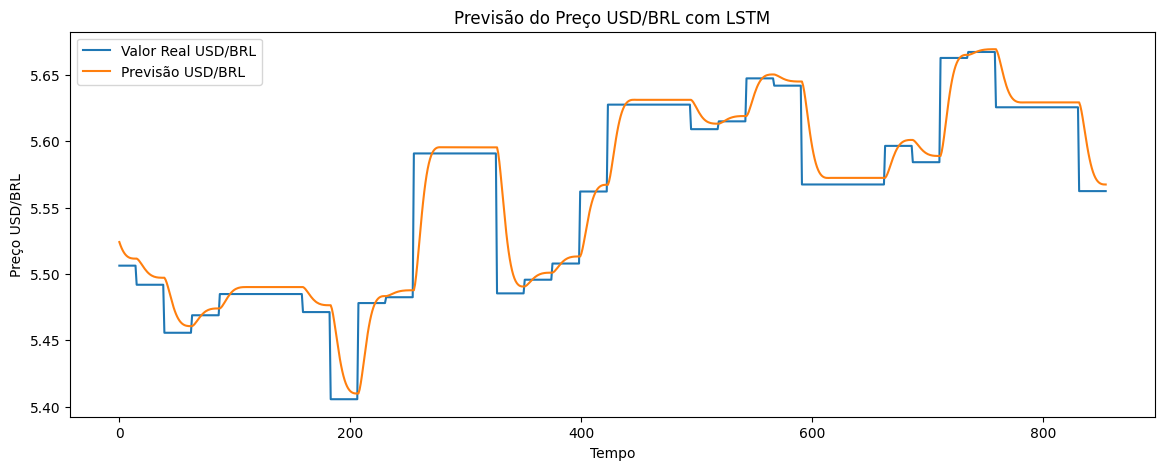

In [57]:
# Previsão
usd_predict = model_usd.predict(X_usd_test)

# Inverter a escala dos dados
usd_predict = scaler_usd.inverse_transform(usd_predict.reshape(-1, 1))
y_usd_test_inv = scaler_usd.inverse_transform(y_usd_test.reshape(-1, 1))

# Calcular RMSE
rmse_usd = np.sqrt(mean_squared_error(y_usd_test_inv, usd_predict))
print(f"RMSE do modelo USD/BRL: {rmse_usd:.4f}")

# Visualização dos resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_usd_test_inv, label='Valor Real USD/BRL')
plt.plot(usd_predict, label='Previsão USD/BRL')
plt.title('Previsão do Preço USD/BRL com LSTM')
plt.xlabel('Tempo')
plt.ylabel('Preço USD/BRL')
plt.legend()
plt.show()

In [58]:
# Preparar dados para Diferença Percentual
X_diff, y_diff = prepare_data(data_diff_scaled, time_step)

# Dividir os dados em treinamento e teste
train_size_diff = int(len(X_diff) * 0.8)
X_diff_train, X_diff_test = X_diff[:train_size_diff], X_diff[train_size_diff:]
y_diff_train, y_diff_test = y_diff[:train_size_diff], y_diff[train_size_diff:]

# Remodelar a entrada
X_diff_train = X_diff_train.reshape(X_diff_train.shape[0], X_diff_train.shape[1], 1)
X_diff_test = X_diff_test.reshape(X_diff_test.shape[0], X_diff_test.shape[1], 1)

# Criar o modelo LSTM para Diferença Percentual
model_diff = Sequential()
model_diff.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_diff.add(LSTM(50))
model_diff.add(Dense(1))
model_diff.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
model_diff.fit(X_diff_train, y_diff_train, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0306
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0035
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0025
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0026
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0020
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0018
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0015
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0016
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0012
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0015


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
RMSE do modelo de Diferença Percentual: 0.3022


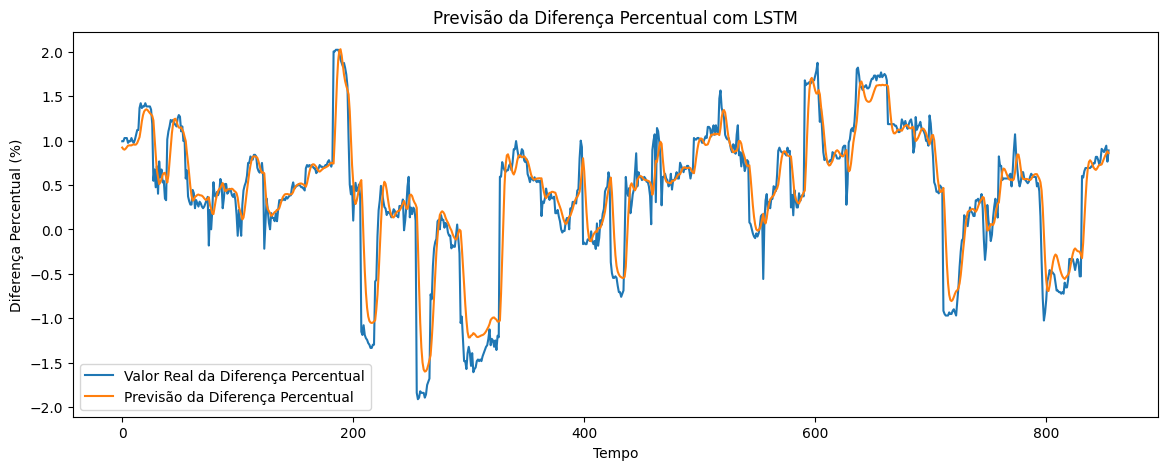

In [59]:
# Previsão
diff_predict = model_diff.predict(X_diff_test)

# Inverter a escala dos dados
diff_predict = scaler_diff.inverse_transform(diff_predict.reshape(-1, 1))
y_diff_test_inv = scaler_diff.inverse_transform(y_diff_test.reshape(-1, 1))

# Calcular RMSE
rmse_diff = np.sqrt(mean_squared_error(y_diff_test_inv, diff_predict))
print(f"RMSE do modelo de Diferença Percentual: {rmse_diff:.4f}")

# Visualização dos resultados
plt.figure(figsize=(14,5))
plt.plot(y_diff_test_inv, label='Valor Real da Diferença Percentual')
plt.plot(diff_predict, label='Previsão da Diferença Percentual')
plt.title('Previsão da Diferença Percentual com LSTM')
plt.xlabel('Tempo')
plt.ylabel('Diferença Percentual (%)')
plt.legend()
plt.show()